# Прогнозирование оттока клиентов

**Описание проекта:** 

Некоторый оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

**Цель проекта:** построить модель, прогнозирующую отток пользователей.

**Используемые данные:** 4 файла из разных источников.
* `contract.csv` — содержит информацию о договоре;
* `personal.csv` — содержит персональные данные клиента;
* `internet.csv` — содержит информацию об интернет-услугах;
* `phone.csv` — содержит информацию информация об услугах телефонии.
Информация актуальна на 1 февраля 2020 года.

## Оглавление
1. [Исследовательский анализ данных](#1)
2. [Предобработка данных](#2)
3. [Обучение моделей](#3)
4. [Проверка модели на тестовой выборке](#4)
5. [Заключение](#5)

<a id="1"></a>
## 1. Исследовательский анализ данных
Импортируем необходимые для работы библиотеки.

In [1]:
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
import pandas as pd

Считаем файлы с данными, для удобства сохраним наборы данных в словарь. 

In [2]:
contract = pd.read_csv("/datasets/final_provider/contract.csv")
personal = pd.read_csv("/datasets/final_provider/personal.csv")
internet = pd.read_csv("/datasets/final_provider/internet.csv")
phone = pd.read_csv("/datasets/final_provider/phone.csv")

In [3]:
data = {
    "contract": contract,
    "personal": personal,
    "internet": internet,
    "phone": phone
}

Убедимся, что данные считались без ошибок.

In [4]:
for name, dataframe in data.items():
    print("Dataframe:", name)
    display(dataframe.head())
    print("\n")
    print(30 * "---")

Dataframe: contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65




------------------------------------------------------------------------------------------
Dataframe: personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




------------------------------------------------------------------------------------------
Dataframe: internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




------------------------------------------------------------------------------------------
Dataframe: phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes




------------------------------------------------------------------------------------------


Данные выглядят нормально. Теперь выведем общую информацию о данных в каждой таблице.

In [5]:
for name, dataframe in data.items():
    print("Dataframe:", name)
    dataframe.info()
    print("\n")
    print(30 * "--")

Dataframe: contract
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


------------------------------------------------------------
Dataframe: personal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-nul

Пропущенных значений нет. Можно заметить, что таблицы разной длины. Это вызвано тем, что не все пользователи используют и интернет, и телефонную связь.

Посмотрим на значения столбца `TotalCharges` в таблице `contract`. Это данные о суммарных платежах клиента, но они представлены типом `object`. Посмотрим на значения этого признака. 

In [6]:
contract_values = contract["TotalCharges"].value_counts()
contract_values

           11
20.2       11
19.75       9
19.9        8
19.65       8
           ..
7774.05     1
155.9       1
921.4       1
811.65      1
2349.8      1
Name: TotalCharges, Length: 6531, dtype: int64

Видно, что в данных есть некорректное значение — пробел вместо числа. Посмотрим, у каких пользователей вместо суммы платежей указан пробел.

In [7]:
contract[contract["TotalCharges"] == " "]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Анализ показывает, что пробел вместо суммы платежей указан у новых пользователей, которые ещё не сделали ни одного платежа, потому что только начали пользоваться услугами компании. Исходя из этого, заменим `TotalCharges` нулём. Также приведём этот признак к правильному типу (`float`). 

In [8]:
to_replace = " "
contract["TotalCharges"].replace(to_replace=to_replace, 
                                 value=0, 
                                 inplace=True)

contract["TotalCharges"] = contract["TotalCharges"].astype(float)

Посмотрим на статистические параметры числовых признаков.

In [9]:
contract.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


Аномалий в признаках не видно, построим гистограммы распределений.

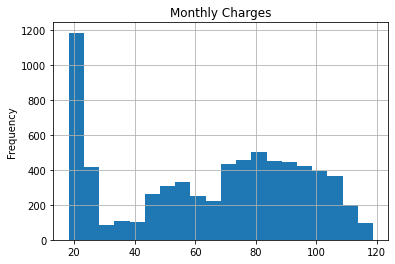

In [10]:
contract["MonthlyCharges"].plot(kind="hist", title="Monthly Charges", 
                                bins=20, grid=True);

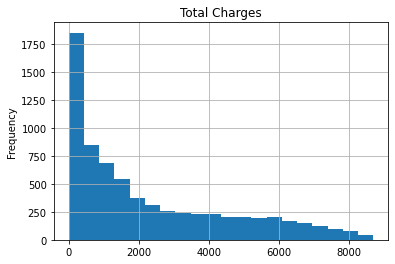

In [11]:
contract["TotalCharges"].plot(kind="hist", title="Total Charges", 
                                bins=20, grid=True);

Здесь ничего не бросается в глаза. На этом закончим исследовать данные и перейдём к предобработке.  

<a id="2"></a>
## 2. Предобработка данных

Поскольку `customerID` — это уникальный идентификатор пользователя, будем использовать его в качестве индексов в таблицах.

In [12]:
for dataset in data.values():
    dataset.set_index("customerID", inplace=True)    

In [13]:
final_df = contract.join(personal, how="outer")
final_df = final_df.join(internet, how="outer")
final_df = final_df.join(phone, how="outer")
final_df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.30,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.40,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
0011-IGKFF,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,98.0,1237.85,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
0013-EXCHZ,2019-09-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,83.9,267.40,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


Убедимся, что не потеряли никакие признаки.

In [14]:
print("Проверка количества признаков:")
print(final_df.shape[1] == contract.shape[1] + personal.shape[1] + internet.shape[1] + phone.shape[1])

Проверка количества признаков:
True


Проверка прошла успешно.

Теперь выделим целевую переменную. Назовём её `target` и добавим в итоговую таблицу. Для того, чтобы сконструировать эту переменную, обратимся к столбцу `EndDate`. Если значение этого признака `No`, то это значит, что клиент не ушёл, поэтому в целевой переменной будет стоять значение `0`. Если значение признака `EndDate` не `0`, то это дата ухода клиента, поэтому в целевой переменной будет значение `1`.

In [15]:
final_df["target"] = final_df["EndDate"].where(final_df["EndDate"] == "No", other=0)
final_df["target"].replace("No", 1, inplace=True)

Поскольку известна дата подключения клиента, то можно посчитать время, в течение которого клиент пользовался услугами компании. Для этого приведём признаки `BeginDate` и `EndDate` к типу `datetime64` и вычтем первый из второго. Если клиент не ушёл (`No` в `EndDate`), то будем вычитать из даты, когда были выгружены данные, `"2020-02-01"`. Результат представим в виде количества дней и запишем в столбец `lifetime`. Столбцы `BeginDate` и `EndDate` исключим из итоговой таблицы.

In [16]:
final_df["BeginDate"] = final_df["BeginDate"].astype("datetime64")

final_df["EndDate"].replace("No", "2020-02-01", inplace=True)
final_df["EndDate"] = final_df["EndDate"].astype("datetime64")

final_df["lifetime"] = (final_df["EndDate"] - final_df["BeginDate"]).dt.days
final_df.drop(columns=["BeginDate", "EndDate"], inplace=True)

In [17]:
final_df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,lifetime
customerID,,,,,,,,,,,,,,,,,,,
0002-ORFBO,One year,Yes,Mailed check,65.6,593.30,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No,1,276
0003-MKNFE,Month-to-month,No,Mailed check,59.9,542.40,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes,1,276
0004-TLHLJ,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No,0,122
0011-IGKFF,Month-to-month,Yes,Electronic check,98.0,1237.85,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,0,396
0013-EXCHZ,Month-to-month,Yes,Mailed check,83.9,267.40,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No,0,91


Теперь разделим данные на обучающую и тестовую выборки.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns="target"), 
                                                    final_df["target"], 
                                                    test_size=0.25, 
                                                    random_state=42)

Данные готовы к использованию в моделях, можно переходить к следующему этапу — обучению моделей.

<a id="3"></a>
## 3. Обучение моделей
Будем производить отбор из четырёх моделей классификации:
* метод опорных векторов (`SVC`);
* логистической регрессии (`LogisticRegression`);
* классификатор на основе случайного леса (`RandomForestClassifier`);
* градиентный бустинг из библиотеки `catboost` (`CatBoostClassifier`).

Будем производить настройку гиперпараметров, используя поиск по решётке *(Grid Search)* и перекрёсную проверку *(cross-validation)*. Для удобства напишем `pipeline`, в котором будет производиться стандартизация числовых признаков и кодирование категориальных признаков. Укажем сетки гиперпараметров для каждого типа моделей и соберём их в список. 

После этого запустим обучение. В этой задаче будем ориентироваться на метрику `roc-auc`.

In [19]:
num_features = ["MonthlyCharges", "TotalCharges", "lifetime"]
cat_features = X_train.drop(columns=num_features).columns

preprocessor = ColumnTransformer([("num", StandardScaler(), num_features),
                                  ("cat", OneHotEncoder(drop="first"), cat_features)])

clf_svc = SVC(class_weight="balanced", 
              probability=True, 
              random_state=42)

clf_logreg = LogisticRegression(class_weight="balanced", 
                                random_state=42)

clf_rf = RandomForestClassifier(class_weight="balanced", 
                                random_state=42)

clf_catboost = CatBoostClassifier(auto_class_weights="Balanced", 
                                  silent=True, 
                                  random_state=42)

param_svc = {
    "classifier__C": [1, 0.1, 0.01],
    "classifier": [clf_svc]
}

param_logreg = {
    "classifier__C": [1, 0.1, 0.01],
    "classifier": [clf_logreg]
}

params_rf = {
    "classifier__n_estimators": [100, 200, 300, 400],
    "classifier__max_depth": [1, 2],
    "classifier": [clf_rf]
}

param_catboost = {
    "classifier__learning_rate": [0.03, 0.02, 0.01],
    "classifier__depth": [1, 2],
    "classifier__iterations": [4000, 5000, 6000, 7000],
    "classifier": [clf_catboost]
}

pipeline = Pipeline([("preprocessor", preprocessor), 
                     ("classifier", clf_svc)])

params = [param_svc, param_logreg, params_rf, param_catboost]

In [20]:
grid_search = GridSearchCV(pipeline, params, scoring="roc_auc").fit(X_train, y_train)

Посмотрим, какая модель и с какими гиперпараметрами оказалась лучшей по итогам перекрёстной проверки.

In [21]:
print("Лучшая модель и использованные гиперпараметры:")
grid_search.best_params_

Лучшая модель и использованные гиперпараметры:


{'classifier': <catboost.core.CatBoostClassifier at 0x7f4bd3e99370>,
 'classifier__depth': 2,
 'classifier__iterations': 7000,
 'classifier__learning_rate': 0.03}

Таким образом, лучшей моделью оказался **градиентный бустинг** (`CatBoostClassifier`). Посмотрим на среднее время обучения моделей с наибольшим значением *AUC ROC* и среднее значение метрики на валидационной выборке при проведении перекрёстной проверки.

In [22]:
def model_class(name):
    if "SVC" in str(type(name)):
        return "SVC"
    elif "Logistic" in str(type(name)):
        return "LogisticRegression"
    elif "Random" in str(type(name)):
        return "RandomForestClassifier"
    else:
        return "CatBoostClassifier"


results = pd.DataFrame(grid_search.cv_results_)
results["model_class"] = results["param_classifier"].apply(model_class)

results_table = (results.groupby("model_class")
                        .max("mean_test_score")[["mean_test_score", "mean_fit_time"]]
                        .sort_values(by="mean_test_score", ascending=False))

results_table.columns = ["Среднее значение AUC ROC", "Среднее время обучения модели, с"]
results_table.index.name = "Тип модели"

In [23]:
results_table

,Среднее значение AUC ROC,"Среднее время обучения модели, с"
Тип модели,,
CatBoostClassifier,0.916337,9.368937
LogisticRegression,0.845885,0.568358
SVC,0.835512,5.019326
RandomForestClassifier,0.832546,0.789734


Наилучшие результаты на валидационной выборке показал **градиентный бустинг**, время обучения которого тоже максимально. Затем идёт **логистическая регрессия**: качество на валидации значительно хуже, однако обучается она на порядок быстрее. Хуже всех справился классификатор на основе **случайного леса**. Возможно, это связано с не очень удачным подбором сетки гиперпараметров. 

Теперь проверим лучшую модель на тестовой выборке.

<a id="4"></a>
## 4. Проверка модели на тестовой выборке
Посчитаем значение метрики `roc-auc` на тестовой выборке.

In [24]:
print(f"Значение roc-auc на тестовой выборке: {roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]):.3f}")

Значение roc-auc на тестовой выборке: 0.928


Также посчитаем значение доли правильных ответов на тестовой выборке (`accuracy`).

In [25]:
print(f"Значение accuracy на тестовой выборке: {accuracy_score(y_test, grid_search.predict(X_test)):.3f}")

Значение accuracy на тестовой выборке: 0.863


<a id="5"></a>
## 5. Заключение

В проекте были выполнены:
* исследовательский анализ данных и их подготовка к использованию в моделях машинного обучения;
* создание дополнительного признака для использования в моделях;
* обучение различных классов моделей, прогнозирующих отток клиентов, и подбор для них оптимальных гиперпараметров;
* анализ полученных моделей и проверка лучшей модели на тестовой выборке.

**Целью проекта** было построение модели машинного обучения, прогнощирующей отток клиентов оператора связи. Такая модель была построена. 

При проведении перекрёстной проверки лучшей оказалась **модель градиентного бустинга** (`CatBoostClassifier`). Модель также показала высокое качество на тестовой выборке: 

* значение *AUC ROC* составило `0.928`;
* значение *accuracy* равно `0.863`.